In [46]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from collections import defaultdict
from datasets import load_dataset
from pandarallel import pandarallel
from time import time
from tokenizers import Tokenizer
import sentencepiece as spm

In [2]:
pandarallel.initialize(nb_workers=12, progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
dataset_test = load_dataset("agemagician/uniref50", split='test+validation')

Found cached dataset csv (/Users/buraksuyunu/.cache/huggingface/datasets/agemagician___csv/agemagician--uniref50-f62b1ddd9530829d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


In [4]:
test_df = pd.DataFrame(dataset_test)

In [5]:
test_df = test_df[test_df['text'].apply(len) < 3000]

In [6]:
test_df

,id,name,text
4,5,UniRef50_A0A819JI93,MIHYELHEQAAKELYEFEEKQQQHPIQREKYLNKKMTNFNRRDFSV...
7,8,UniRef50_A0A1L9QV50,MFADKTLNRPIGIVFEEQVWKAPDRVAIASNNHQWTYQTLNSRANA...
8,9,UniRef50_A0A3N5JKR9,MKKSILVFMLAAALAVLAFAAGMGQKKNPLFSKSAVQYDSSGIKLK...
9,10,UniRef50_A0A2A9MDS8,MTAASVPRHGQDAASPPRSPGSLSASRSRSLSPSSQASRASPLGAA...
10,11,UniRef50_UPI001E677C57,MSGSSDSRAEGGIKKRNIISVHEKLKLIEKLEDGASVASMALEFGI...
...,...,...,...
11967,6080,UniRef50_A0A0E9P7D0,MLGFYFCVFSHCVFSSSLS
11968,6081,UniRef50_A0A553RPB3,MLCEVQHSLYREYLSLL
11969,6082,UniRef50_A0A2P2R4G9,MCHYCVSHNINHMY
11970,6083,UniRef50_A0A8F3CQA7,LXSLFGNDQLLQ


In [156]:
tokenizer_list = {
    'bpe_400': Tokenizer.from_file("../RSRC/progress2/bpe_400.json"),
    'bpe_800': Tokenizer.from_file("../RSRC/progress2/bpe_800.json"),
    'bpe_1600': Tokenizer.from_file("../RSRC/progress2/bpe_1600.json"),
    'bpe_3200': Tokenizer.from_file("../RSRC/progress2/bpe_3200.json"),
    'bpe_6400': Tokenizer.from_file("../RSRC/progress2/bpe_6400.json"),
    'wp_400': Tokenizer.from_file("../RSRC/progress2/wp_400.json"),
    'wp_800': Tokenizer.from_file("../RSRC/progress2/wp_800.json"),
    'wp_1600': Tokenizer.from_file("../RSRC/progress2/wp_1600.json"),
    'wp_3200': Tokenizer.from_file("../RSRC/progress2/wp_3200.json"),
    'wp_6400': Tokenizer.from_file("../RSRC/progress2/wp_6400.json"),
    'spm_400': spm.SentencePieceProcessor("../RSRC/progress2/spm_400.model"),
    'spm_800': spm.SentencePieceProcessor("../RSRC/progress2/spm_800.model"),
    'spm_1600': spm.SentencePieceProcessor("../RSRC/progress2/spm_1600.model"),
    'spm_3200': spm.SentencePieceProcessor("../RSRC/progress2/spm_3200.model"),
    'spm_6400': spm.SentencePieceProcessor("../RSRC/progress2/spm_6400.model")
}

In [160]:
vocab_list = {}
for name, tokenizer in tokenizer_list.items():
    if name.startswith('spm'):
        with open(f"../RSRC/progress2/{name}.vocab") as f:
            vocab_list[name] = list(set([l.strip().split()[0].strip('▁') for l in f.readlines()][3:]))[1:]
    else:
        vocab_list[name] = list(set([token.strip('##') for token, idx in tokenizer.get_vocab().items() if not token.startswith('[')]))

---

In [162]:
for name, tokenizer in tqdm(list(tokenizer_list.items())[-2:]):
    if name.startswith('spm'):
        test_df[name] = [enc for enc in tokenizer.encode_as_pieces(list(test_df['text']))]
    else:
        test_df[name] = [enc.tokens for enc in tokenizer.encode_batch(test_df['text'])]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.83it/s]


In [164]:
with open(f'../RSRC/progress2/agemagician_uniref50_bpe_wp_spm_df.pickle', 'wb') as f:
    pickle.dump(test_df, f, pickle.HIGHEST_PROTOCOL)

1. **Shared Token Counts:** The number of tokens shared between vocabularies of different tokenizers, offering insight into segmentation consistency.
2. **Token Length Distribution:** Distribution of token lengths in the vocabulary, reflecting the granularity of the segmentation.
3. **Fertility:** The average number of tokens required to represent a protein sequence, indicating encoding efficiency.
4. **Contextual Exponence:** The diversity of neighboring tokens each token encounters, shedding light on semantic relationships.
5. **Zipf's Law:** The inverse proportionality between token frequency and rank, indicating linguistic regularity.
6. **Brevity Law:** The tendency of frequently used tokens to be shorter.
7. **Heaps' Law:** The growth of vocabulary size with dataset size, but at a decreasing rate.
8. **Menzerath's Law:** The inverse relationship between the length of a protein sequence and the length of its tokens.

In [154]:
with open(f'../RSRC/progress2/agemagician_uniref50_bpe_wp_spm_df.pickle', 'rb') as f:
    test_df = pickle.load(f)

In [165]:
for tokenizer_name in tqdm(['wp_400', 'wp_800', 'wp_1600', 'wp_3200', 'wp_6400']):
    test_df[tokenizer_name] = test_df[tokenizer_name].apply(lambda seq: [tok.strip('##') for tok in seq])
    
for tokenizer_name in tqdm(['spm_400', 'spm_800', 'spm_1600', 'spm_3200', 'spm_6400']):
    test_df[tokenizer_name] = test_df[tokenizer_name].apply(lambda seq: [tok.strip('▁') for tok in seq])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.37it/s]


In [166]:
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns

In [256]:
plt.rcParams["figure.figsize"] = (7, 7)
sns.set()
sns.color_palette("Spectral", as_cmap=True)
sns.set_style("whitegrid")
colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue']

label_pad = 6
title_pad = 15

In [294]:
methods = ['bpe', 'wp', 'spm']
methods2names = {'bpe':'BPE', 'wp':'WordPiece', 'spm':'SentencePiece'}
vocab_sizes = ['400', '800', '1600', '3200', '6400']

## Shared Token Counts:

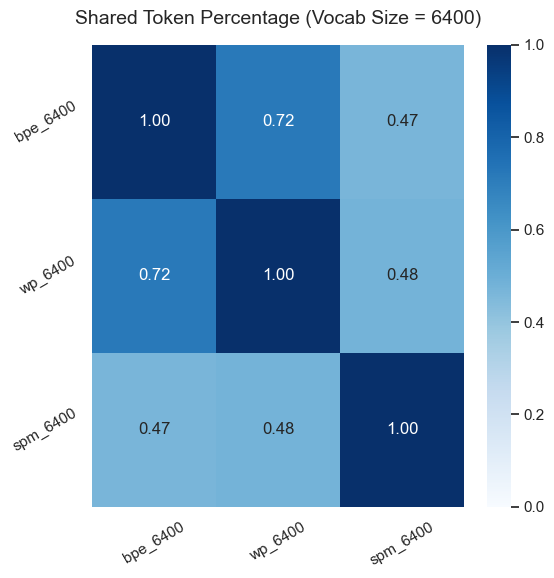

In [274]:
vocab_size = 6400
comp_tokenizers_list = [f'bpe_{vocab_size}', f'wp_{vocab_size}', f'spm_{vocab_size}']

data = np.array(np.zeros((3,3)))
for i in range(len(comp_tokenizers_list)):
    for j in range(i, len(comp_tokenizers_list)):
        data[i][j] = len(set(vocab_list[comp_tokenizers_list[i]]).intersection(set(vocab_list[comp_tokenizers_list[j]])))
        data[i][j] /= min(len(vocab_list[comp_tokenizers_list[i]]), len(vocab_list[comp_tokenizers_list[j]]))
        data[j][i] = data[i][j]
# data = data.astype(int)

fig,ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)

sns.heatmap(data, annot = True, fmt='.2f', xticklabels=comp_tokenizers_list, yticklabels=comp_tokenizers_list, vmax=1, vmin=0, cmap='Blues')
plt.yticks(rotation=30)
plt.xticks(rotation=30)

plt.title(f"Shared Token Percentage (Vocab Size = {vocab_size})", pad=title_pad, size=14)

plt.savefig(f'../RSRC/progress2/figures/shared_token_percent_{vocab_size}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/shared_token_percent_{vocab_size}.png', bbox_inches='tight')
plt.show()

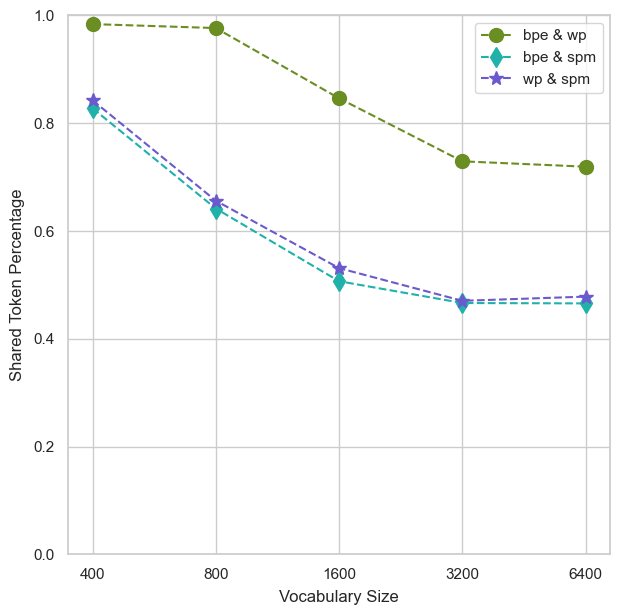

In [1282]:
sns.set_style("whitegrid")
markers = ["o--", "d--", "*--"]

for i, (method1, method2) in enumerate([('bpe', 'wp'), ('bpe', 'spm'), ('wp', 'spm')]):
    shared_token_percs = []
    for vocab_size in vocab_sizes:
        tokenizer1 = f'{method1}_{vocab_size}'
        tokenizer2 = f'{method2}_{vocab_size}'
        shared_token_percs.append(len(set(vocab_list[tokenizer1]).intersection(set(vocab_list[tokenizer2]))))
        shared_token_percs[-1] /= min(len(vocab_list[tokenizer1]), len(vocab_list[tokenizer2]))
    plt.plot(vocab_sizes, shared_token_percs, markers[i], color=colors[i], markersize=10, label=f'{method1} & {method2}')


# plt.title(f"Shared Token Percentage Change of Vocab Sizes Between BPE and WordPiece", pad=title_pad, size=13)
plt.legend()
plt.ylim(top=1, bottom=0)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Shared Token Percentage", labelpad=label_pad);
plt.savefig(f'../RSRC/progress2/figures/shared_token_percent_plot.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/shared_token_percent_plot.png', bbox_inches='tight')

## Token Length Distribution

Distribution of token lengths in the vocabulary, reflecting the granularity of the segmentation.

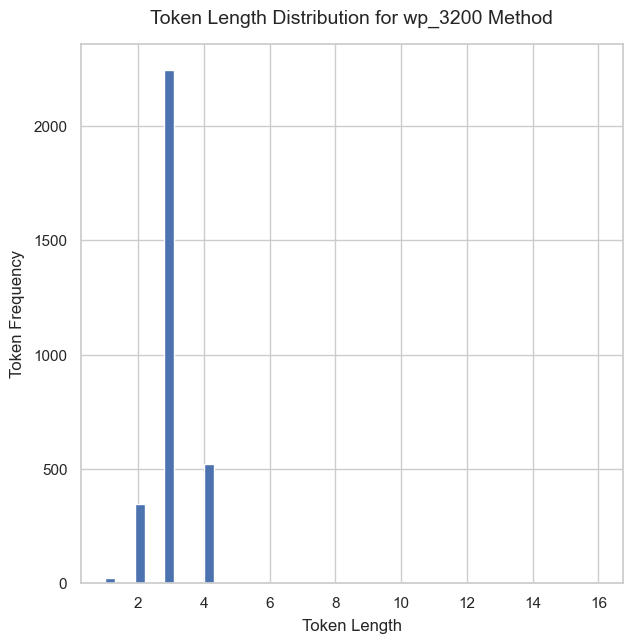

In [357]:
tokenizer_name = 'wp_3200'

tokens_df = pd.DataFrame(vocab_list[tokenizer_name], columns=["token"])
tokens_df["len"] = tokens_df["token"].apply(len)

tokens_df[tokens_df['len']>=0]["len"].hist(bins=50)
plt.title(f"Token Length Distribution for {tokenizer_name} Method", pad=title_pad, size=14)
plt.xlabel("Token Length", labelpad=label_pad)
plt.ylabel("Token Frequency", labelpad=label_pad)
# plt.savefig(f'../RSRC/progress2/figures/token_length_{tokenizer_name}.pdf', bbox_inches='tight')
# plt.savefig(f'../RSRC/progress2/figures/token_length_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

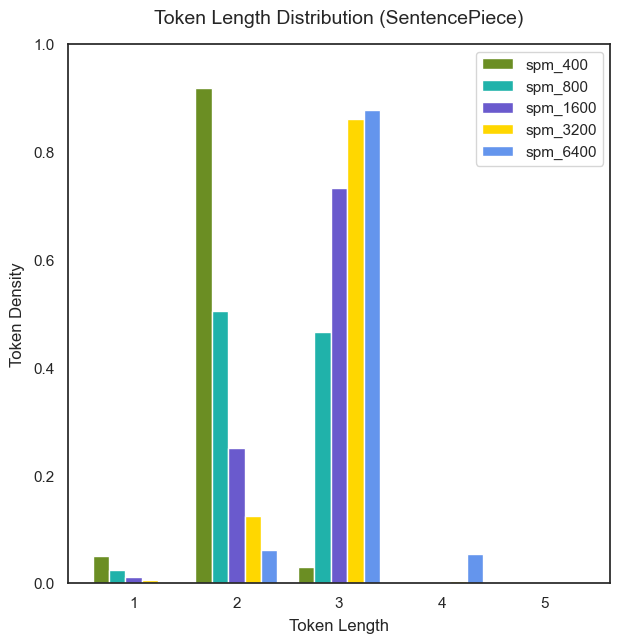

In [348]:
sns.set_style("white")

method = methods[2]
comp_tokenizers_list = [f"{method}_{vocab_size}" for vocab_size in vocab_sizes]

a = plt.hist([[len(token) for token in vocab_list[name]] for name in comp_tokenizers_list], [0.5,1.5,2.5,3.5,4.5,5.5], histtype='bar', label=comp_tokenizers_list, density=True, color=colors)

plt.title(f"Token Length Distribution ({methods2names[method]})", pad=title_pad, size=14)
plt.xlabel("Token Length", labelpad=label_pad)
plt.ylabel("Token Density", labelpad=label_pad)
plt.ylim((0,1))
plt.legend()
plt.savefig(f'../RSRC/progress2/figures/token_length_dist_{method}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/token_length_dist_{method}.png', bbox_inches='tight')
plt.show()

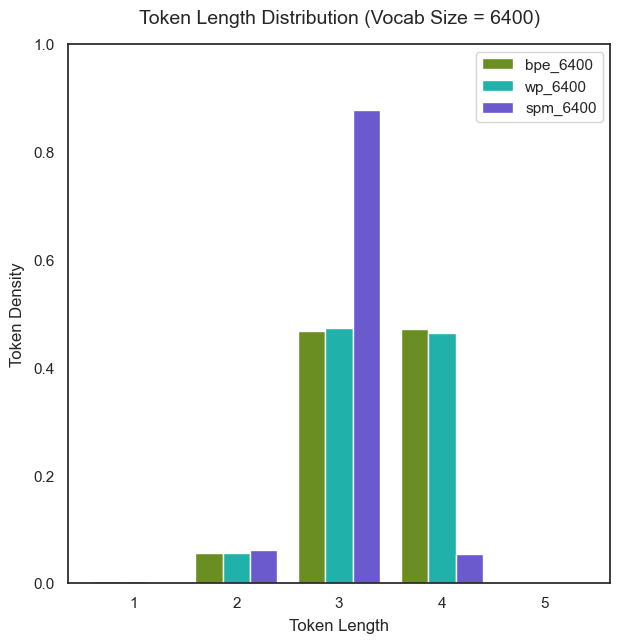

In [401]:
sns.set_style("white")

vocab_size = vocab_sizes[4]
comp_tokenizers_list = [f"{method}_{vocab_size}" for method in methods]

a = plt.hist([[len(token) for token in vocab_list[name]] for name in comp_tokenizers_list], [0.5,1.5,2.5,3.5,4.5,5.5], histtype='bar', label=comp_tokenizers_list, density=True, color=colors[:3])

plt.title(f"Token Length Distribution (Vocab Size = {vocab_size})", pad=title_pad, size=14)
plt.xlabel("Token Length", labelpad=label_pad)
plt.ylabel("Token Density", labelpad=label_pad)
plt.ylim((0,1))
plt.legend()
plt.savefig(f'../RSRC/progress2/figures/token_length_dist_{vocab_size}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/token_length_dist_{vocab_size}.png', bbox_inches='tight')
plt.show()

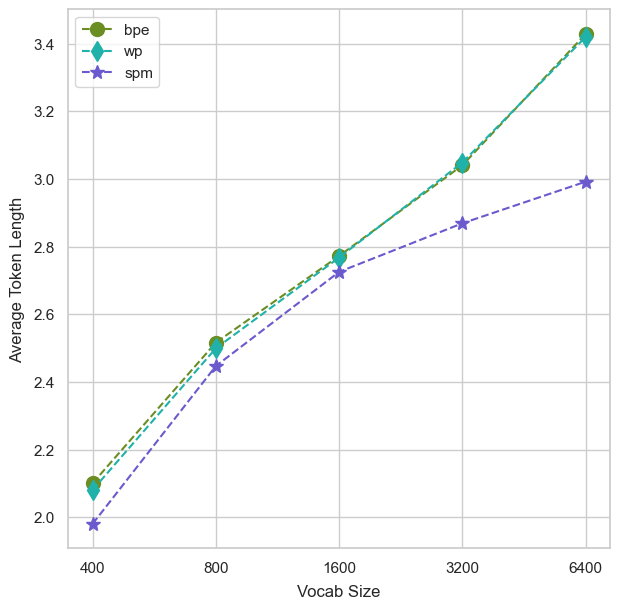

In [1281]:
for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [np.mean([len(token) for token in vocab_list[f'{method}_{vocab_size}']]) for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=method)

# plt.title(f"Average Token Length", pad=title_pad, size=14)
plt.xlabel("Vocab Size", labelpad=label_pad)
plt.ylabel("Average Token Length", labelpad=label_pad)
plt.legend()

plt.savefig(f'../RSRC/progress2/figures/token_length_plot.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/token_length_plot.png', bbox_inches='tight')

plt.show()

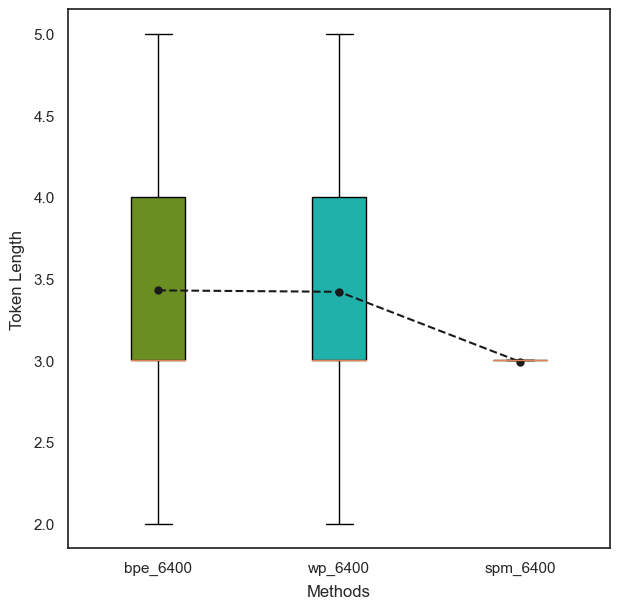

In [344]:
# comp_tokenizers_list = ['bpe_6400', 'wp_6400', 'spm_6400']
# # comp_tokenizers_list = ['bpe_400', 'bpe_800', 'bpe_1600', 'bpe_3200', 'bpe_6400']
# # comp_tokenizers_list = ['wp_400', 'wp_800', 'wp_1600', 'wp_3200', 'wp_6400']

# fig, ax1 = plt.subplots()

# bplot = ax1.boxplot([[len(token) for token in vocab_list[name]] for name in comp_tokenizers_list],
#                      # autorange=True,
#                      showfliers=False,
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=comp_tokenizers_list)  # will be used to label x-ticks

# # ax1.set_title(f"Token Length Distribution for Various Methods", pad=title_pad, size=14)

# # fill with colors
# for patch, color in zip(bplot['boxes'], colors[:len(comp_tokenizers_list)]):
#     patch.set_facecolor(color)

# # adding horizontal grid lines

# ax1.plot(range(1,len(comp_tokenizers_list)+1), [np.mean([len(token) for token in vocab_list[name]]) for name in comp_tokenizers_list], "k.--", markersize=10)

# plt.xlabel("Methods", labelpad=label_pad)
# plt.ylabel("Token Length", labelpad=label_pad)


# # plt.savefig(f'../RSRC/progress2/figures/token_length_{tokenizer_name}.pdf', bbox_inches='tight')
# # plt.savefig(f'../RSRC/progress2/figures/token_length_{tokenizer_name}.png', bbox_inches='tight')

# plt.show()

In [359]:
{name: np.mean([len(token) for token in vocab]) for name, vocab in vocab_list.items()}

{'bpe_400': 2.1,
 'bpe_800': 2.51625,
 'bpe_1600': 2.7725,
 'bpe_3200': 3.0409375,
 'bpe_6400': 3.42921875,
 'wp_400': 2.08,
 'wp_800': 2.4993514915693904,
 'wp_1600': 2.767857142857143,
 'wp_3200': 3.048966613672496,
 'wp_6400': 3.4205830810896924,
 'spm_400': 1.9797468354430379,
 'spm_800': 2.446835443037975,
 'spm_1600': 2.72544080604534,
 'spm_3200': 2.8692235146180445,
 'spm_6400': 2.9923125196109193}

## Fertility
The average number of tokens required to represent a protein sequence, indicating encoding efficiency.

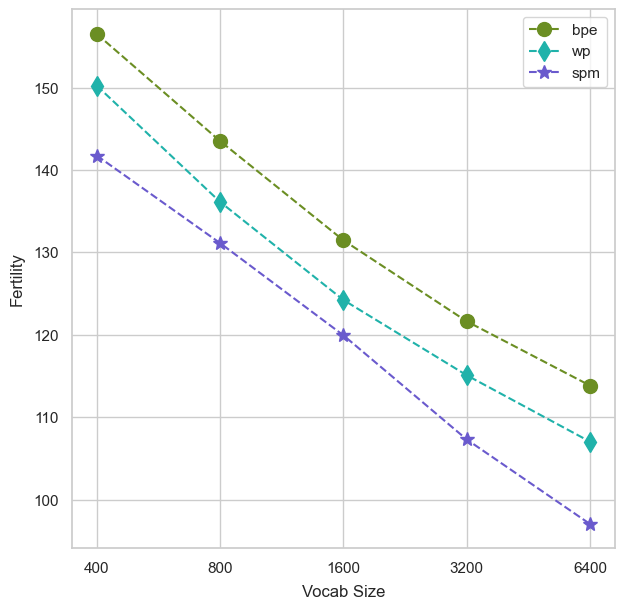

In [1280]:
for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [test_df[f'{method}_{vocab_size}'].apply(len).mean() for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=method)

# plt.title(f"Average Token Length", pad=title_pad, size=14)
plt.xlabel("Vocab Size", labelpad=label_pad)
plt.ylabel("Fertility", labelpad=label_pad)
plt.legend()

plt.savefig(f'../RSRC/progress2/figures/fertility_plot.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/fertility_plot.png', bbox_inches='tight')

plt.show()

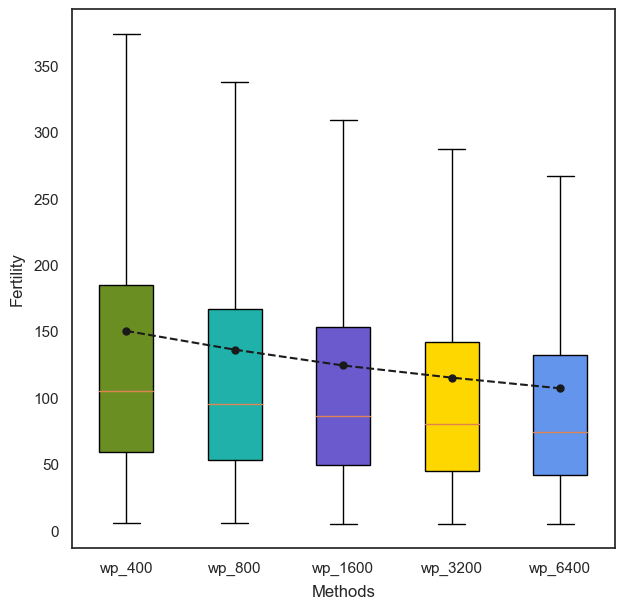

In [367]:
# comp_tokenizers_list = ['bpe_1600', 'wp_1600', 'spm_1600']
# # comp_tokenizers_list = ['bpe_400', 'bpe_800', 'bpe_1600', 'bpe_3200', 'bpe_6400']
# comp_tokenizers_list = ['wp_400', 'wp_800', 'wp_1600', 'wp_3200', 'wp_6400']

# fig, ax1 = plt.subplots()
# bplot = ax1.boxplot([test_df[name].apply(len) for name in comp_tokenizers_list],
#                      # autorange=True,
#                      showfliers=False,
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=comp_tokenizers_list)  # will be used to label x-ticks

# # ax1.set_title(f"Token Length Distribution for Various Methods", pad=title_pad, size=14)

# for patch, color in zip(bplot['boxes'], colors[:len(comp_tokenizers_list)]):
#     patch.set_facecolor(color)

# # adding horizontal grid lines

# ax1.plot(range(1,len(comp_tokenizers_list)+1), [test_df[name].apply(len).mean() for name in comp_tokenizers_list], "k.--", markersize=10)

# plt.xlabel("Methods", labelpad=label_pad)
# plt.ylabel("Fertility", labelpad=label_pad)

# # plt.savefig(f'../RSRC/progress2/figures/token_length_{tokenizer_name}.pdf', bbox_inches='tight')
# # plt.savefig(f'../RSRC/progress2/figures/token_length_{tokenizer_name}.png', bbox_inches='tight')

# plt.show()

## Contextual Exponence
The diversity of neighboring tokens each token encounters, shedding light on semantic relationships.

In [369]:
token_neighs = {}

window_size = 2
for name in tqdm(vocab_list.keys()):
    temp_neighs = {}
    for seq in test_df[name]:
        for i, tok in enumerate(seq):
            if tok not in temp_neighs:
                temp_neighs[tok] = []
            temp_neighs[tok].extend(seq[max(i-window_size, 0):i])
            temp_neighs[tok].extend(seq[i+1:min(i+window_size+1, len(seq))])
    token_neighs[name] = temp_neighs
    
token_neighs_unq_len = {name: {token: len(set(neighs)) for token, neighs in tokens.items()} for name, tokens in token_neighs.items()}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.59s/it]


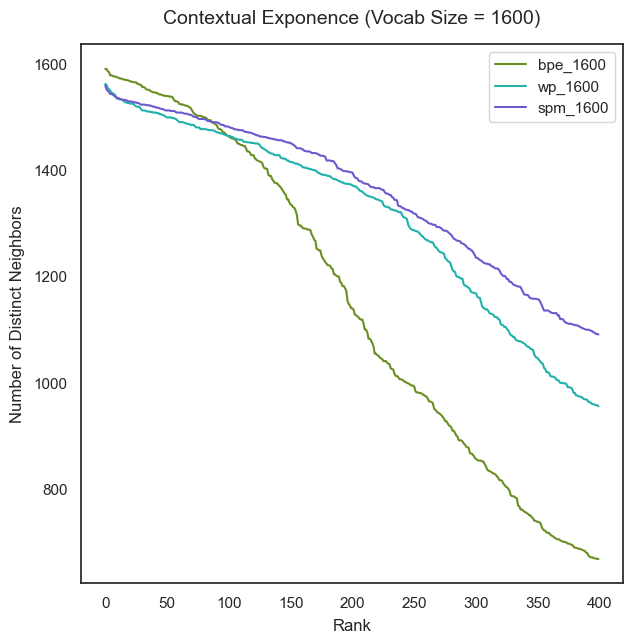

In [1284]:
sns.set_style("white")
names = ['bpe', 'wp', 'spm']
vocab_size = 1600

for idx, method in enumerate(methods):
    plt.plot([t[1] for t in sorted(token_neighs_unq_len[f'{method}_{vocab_size}'].items(), key=lambda x: -x[1])[:400]], color=colors[idx], label=f'{method}_{vocab_size}')

plt.title(f"Contextual Exponence (Vocab Size = {vocab_size})", pad=title_pad, size=14)
plt.xlabel("Rank", labelpad=label_pad)
plt.ylabel("Number of Distinct Neighbors", labelpad=label_pad)
plt.legend()

# plt.savefig(f'../RSRC/progress2/figures/contextual_exponence_plot_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'../RSRC/progress2/figures/contextual_exponence_plot_{vocab_size}.png', bbox_inches='tight')

plt.show()

## Zipf's law

In [435]:
from collections import Counter
from scipy.stats import linregress

In [713]:
token_freqs_dict = {}
for tokenizer_name in tqdm(vocab_list.keys()):
    token_freqs_dict[tokenizer_name] = test_df[tokenizer_name].apply(Counter).sum().copy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:37<00:00, 10.47s/it]


In [723]:
for tokenizer_name in tqdm(vocab_list.keys()):
    to_del = []
    for k, v in token_freqs_dict[tokenizer_name].items():
        if k not in vocab_list[tokenizer_name]:
            to_del.append(k)
    for k in to_del:
        del token_freqs_dict[tokenizer_name][k]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.06it/s]


In [727]:
zipf_slopes = {}
for tokenizer_name, token_freqs in token_freqs_dict.items():
    freqs = np.array(list(token_freqs.values()))
    sorted_freqs = np.sort(freqs)[::-1]
    y_data = np.log(sorted_freqs)
    x_data = np.log(np.array(range(1, len(sorted_freqs) + 1)))
    
    x_masked = x_data.copy()
    y_masked = y_data.copy()
    
#     mask = (x_data > 0.0) & (x_data < 100.0)
#     x_masked = x_data[mask]
#     y_masked = y_data[mask]
    
    zipf_slopes[tokenizer_name] = linregress(x_masked, y_masked).slope

In [730]:
zipf_slopes

{'bpe_400': -1.0430469021579705,
 'bpe_800': -1.1465360815613486,
 'bpe_1600': -1.1278102976171822,
 'bpe_3200': -1.1571231056757978,
 'bpe_6400': -1.1963725455031275,
 'wp_400': -0.7700774922309049,
 'wp_800': -0.9369427132843164,
 'wp_1600': -0.939500775131856,
 'wp_3200': -1.008572264085461,
 'wp_6400': -1.0738982719813237,
 'spm_400': -0.6171789918009052,
 'spm_800': -0.9319480658998788,
 'spm_1600': -0.8895555329924415,
 'spm_3200': -0.7061396034759575,
 'spm_6400': -0.6743617731162114}

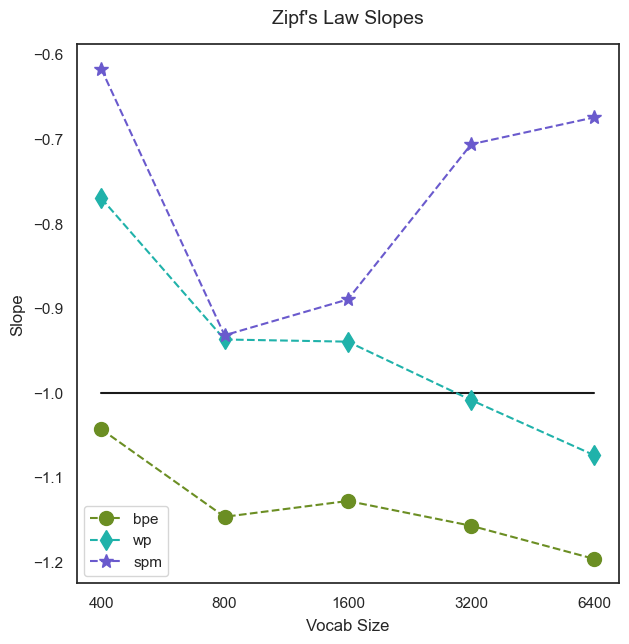

In [1289]:
sns.set_style("white")
plt.plot(vocab_sizes, [-1 for _ in vocab_sizes], 'k-')

for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [zipf_slopes[f'{method}_{vocab_size}'] for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=method)

plt.title(f"Zipf's Law Slopes", pad=title_pad, size=14)
plt.xlabel("Vocab Size", labelpad=label_pad)
plt.ylabel("Slope", labelpad=label_pad)
plt.legend()

plt.savefig(f'../RSRC/progress2/figures/zipf_slope_plot.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/zipf_slope_plot.png', bbox_inches='tight')

plt.show()

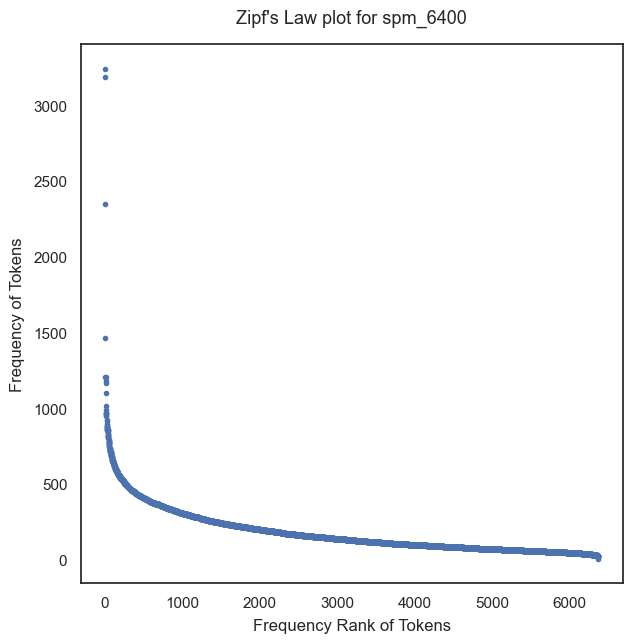

In [754]:
tokenizer_name = 'spm_6400'
token_freqs = token_freqs_dict[tokenizer_name]

freqs = np.array(list(token_freqs.values()))
sorted_freqs = np.sort(freqs)[::-1]

y_data = sorted_freqs
x_data = np.array(range(1, len(sorted_freqs) + 1))

plt.plot(x_data, y_data, ".")
plt.title(f"Zipf's Law plot for {tokenizer_name}", pad=title_pad, size=13)
# plt.xlim([-100, 3000])
plt.xlabel("Frequency Rank of Tokens", labelpad=label_pad)
plt.ylabel("Frequency of Tokens", labelpad=label_pad)
plt.savefig(f'../RSRC/progress2/figures/zipf_{tokenizer_name}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/zipf_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

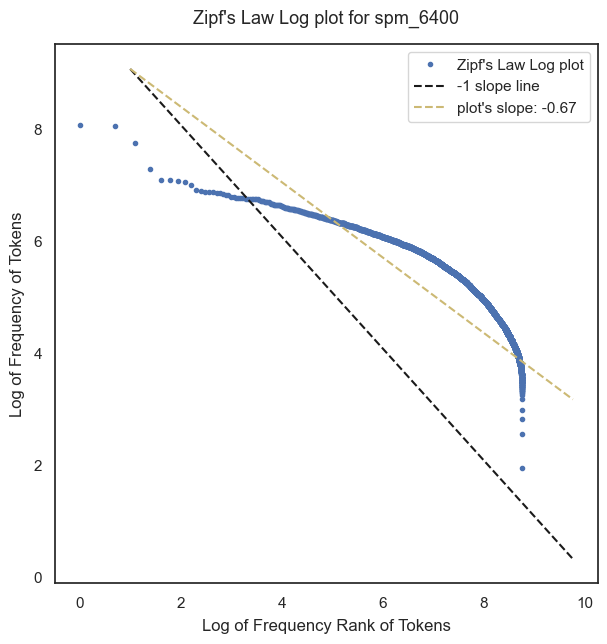

In [755]:
y_data = np.log(sorted_freqs)
x_data = np.log(np.array(range(1, len(sorted_freqs) + 1)))

x_masked = x_data.copy()
y_masked = y_data.copy()

# mask = (x_data > 0.0) & (x_data < 100.0)
# x_masked = x_data[mask]
# y_masked = y_data[mask]

slope = linregress(x_masked, y_masked).slope

plt.plot(x_data, y_data, ".", label="Zipf's Law Log plot")
plt.plot(x_data+1, -1*x_data+y_data[0]+1, "--", color='k', label="-1 slope line")
plt.plot(x_data+1, slope*x_data+y_data[0]-slope*x_data[0]+1, "--", color='y', label=f"plot's slope: {slope:.2f}")
plt.title(f"Zipf's Law Log plot for {tokenizer_name}", pad=title_pad, size=13)
plt.xlabel("Log of Frequency Rank of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
plt.legend()
plt.savefig(f'../RSRC/progress2/figures/zipf_log_{tokenizer_name}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/zipf_log_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

In [594]:
# mask = (x_data > 0.0) & (x_data < 100.0)

# x_masked = x_data[mask]
# y_masked = y_data[mask]

# plt.plot(x_masked, y_masked, ".")
# plt.plot(x_masked, -1*x_masked+y_masked[0]+x_masked[0], "-", color='k')
# # plt.plot(x_masked, linregress(x_data, y_data).slope*x_masked+y_masked[0]-linregress(x_data, y_data).slope*x_masked[0], "--", color='r')
# plt.plot(x_masked, linregress(x_masked, y_masked).slope*x_masked+y_masked[0]-linregress(x_masked, y_masked).slope*x_masked[0], "--", color='y')
# plt.title("Zipf's Law plot for Tokens - Partial", pad=title_pad, size=13)
# # plt.xlabel("Log of Frequency Rank of Tokens", labelpad=label_pad)
# # plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
# plt.show()

In [595]:
# linregress(x_data, y_data).slope

In [596]:
# linregress(x_masked, y_masked).slope

## Brevity law

çok geçen kısa olur. geçme sayısının log u ( veya milyon cinsinden) vs uzunluğunu plot et.

In [756]:
token_freqs_dict.keys()

dict_keys(['bpe_400', 'bpe_800', 'bpe_1600', 'bpe_3200', 'bpe_6400', 'wp_400', 'wp_800', 'wp_1600', 'wp_3200', 'wp_6400', 'spm_400', 'spm_800', 'spm_1600', 'spm_3200', 'spm_6400'])

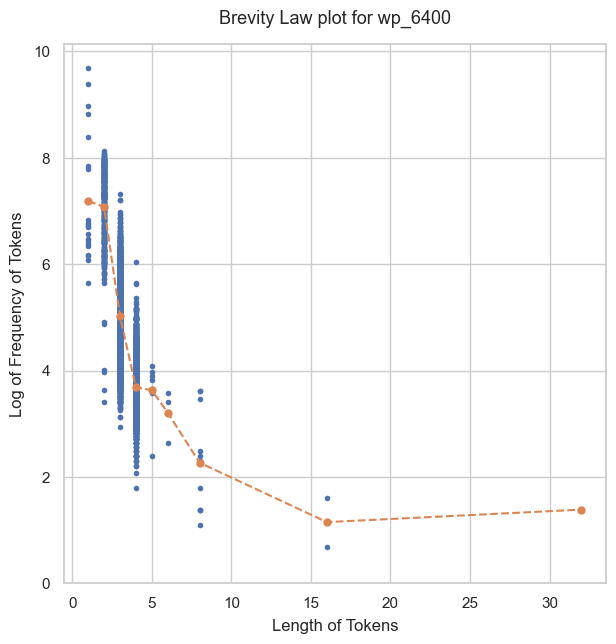

In [1310]:
sns.set_style("whitegrid")
tokenizer_name = 'wp_6400'
token_freqs = token_freqs_dict[tokenizer_name]

freqs = np.log(np.array(list(token_freqs.values())))
lengths = np.array([len(token) for token in list(token_freqs.keys())])

plt.plot(lengths, freqs, ".")

lf_df = pd.DataFrame([lengths, freqs]).T
lf_df = lf_df.rename(columns={0:'lengths', 1:'freqs'})
lf_df['lengths'] = lf_df['lengths'].astype(int)
lf_mean = lf_df.groupby('lengths')['freqs'].mean()
plt.plot(lf_mean.index, lf_mean, '.--', markersize=10)

plt.title(f"Brevity Law plot for {tokenizer_name}", pad=title_pad, size=13)
plt.ylim(bottom=0)
plt.xlabel("Length of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
plt.savefig(f'../RSRC/progress2/figures/brevity_{tokenizer_name}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/brevity_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

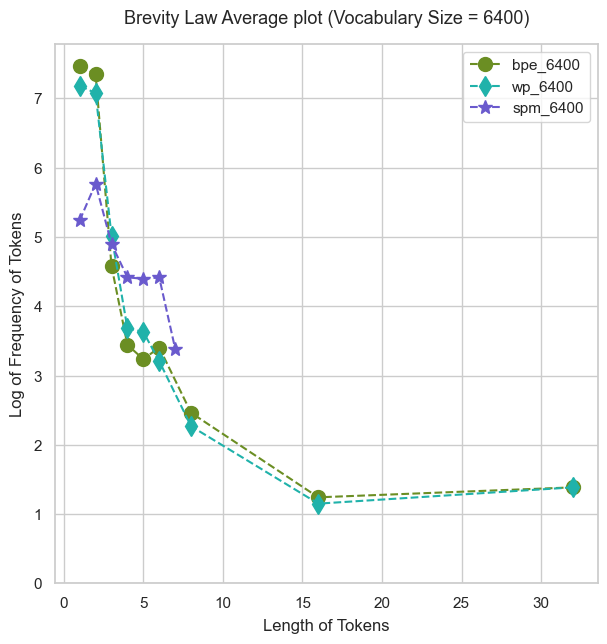

In [1315]:
sns.set_style("whitegrid")
vocab_size = 6400
for idx, method in enumerate(methods):
    tokenizer_name = f'{method}_{vocab_size}'
    token_freqs = token_freqs_dict[tokenizer_name]

    freqs = np.log(np.array(list(token_freqs.values())))
    lengths = np.array([len(token) for token in list(token_freqs.keys())])

    # plt.plot(lengths, freqs, ".", color=colors[idx])

    lf_df = pd.DataFrame([lengths, freqs]).T
    lf_df = lf_df.rename(columns={0:'lengths', 1:'freqs'})
    lf_df['lengths'] = lf_df['lengths'].astype(int)
    lf_mean = lf_df.groupby('lengths')['freqs'].mean()
    plt.plot(lf_mean.index, lf_mean, markers[idx], color=colors[idx], markersize=10, label=tokenizer_name)

plt.title(f"Brevity Law Average plot (Vocabulary Size = {vocab_size})", pad=title_pad, size=13)
plt.ylim(bottom=0)
plt.xlabel("Length of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
plt.legend()
plt.savefig(f'../RSRC/progress2/figures/brevity_avg_{vocab_size}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/brevity_avg_{vocab_size}.png', bbox_inches='tight')
plt.show()

## Heap's Law

The number of distinct words in a document (or set of documents) as a function of the document length. Proteinlerin icerdigi kumulatif distinct token sayisi logaritmik olarak degisir. Proteinleri rastgele sirala. Sirayla gez ve icerdikleri distinct tokenlari kumulatif olarak say. ligaritmik vir plot cikmasi lazim.

In [763]:
np.random.seed(10)
heaps_dict = {}
test_df_permutation = np.random.permutation(len(test_df))

for tokenizer_name in tqdm(tokenizer_list.keys()):
    tokens_set = set()
    unique_tokens_count = [0]
    all_tokens_count = [0]
    for i in test_df_permutation:
        tokens_set = tokens_set.union(test_df[tokenizer_name].iloc[i])
        unique_tokens_count.append(len(tokens_set))
        all_tokens_count.append(all_tokens_count[-1]+len(test_df[tokenizer_name].iloc[i]))
    heaps_dict[tokenizer_name] = (unique_tokens_count, all_tokens_count)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.25it/s]


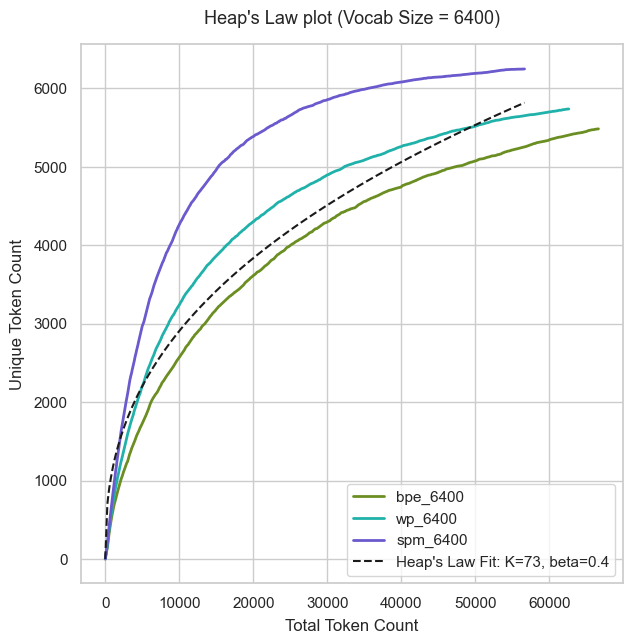

In [1495]:
vocab_size = 6400

max_index = 0
for method in methods:
    tokenizer_name = f'{method}_{vocab_size}'
    pareto_max = int(heaps_dict[tokenizer_name][0][-1]*.8)
    for i, cnt in enumerate(heaps_dict[tokenizer_name][0]):
        if cnt >= pareto_max:
            if i > max_index:
                max_index = i
            break

for i, method in enumerate(methods):
    tokenizer_name = f'{method}_{vocab_size}'
    y_data = heaps_dict[tokenizer_name][0][:max_index+vocab_size//50]
    x_data = heaps_dict[tokenizer_name][1][:max_index+vocab_size//50]
    plt.plot(x_data, y_data, "-", linewidth=2, color=colors[i], label=tokenizer_name)
    
K = 73
beta = 0.4

plt.plot(x_data, K*np.array(x_data)**beta, "--k", linewidth=1.5, label=f"Heap's Law Fit: K={K}, beta={beta}")

plt.title(f"Heap's Law plot (Vocab Size = {vocab_size})", pad=title_pad, size=13)
# plt.xlim([0, 400000])
# plt.ylim([0, 10500])
plt.xlabel("Total Token Count", labelpad=label_pad)
plt.ylabel("Unique Token Count", labelpad=label_pad)
plt.legend()
plt.savefig(f'../RSRC/progress2/figures/heap_{vocab_size}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/heap_{vocab_size}.png', bbox_inches='tight')
plt.show()

## Menzerath's law

The longer a word (in syllables), the shorter its syllables (in letters or phonemes). Her bir protein icin proteinin kac token icerdigi vs tokenlarin ortalama length i. Beklenen durum: protein icindeki toplam token sayisi arttikca tokenlarin ortalama uzunlugu azalmali.

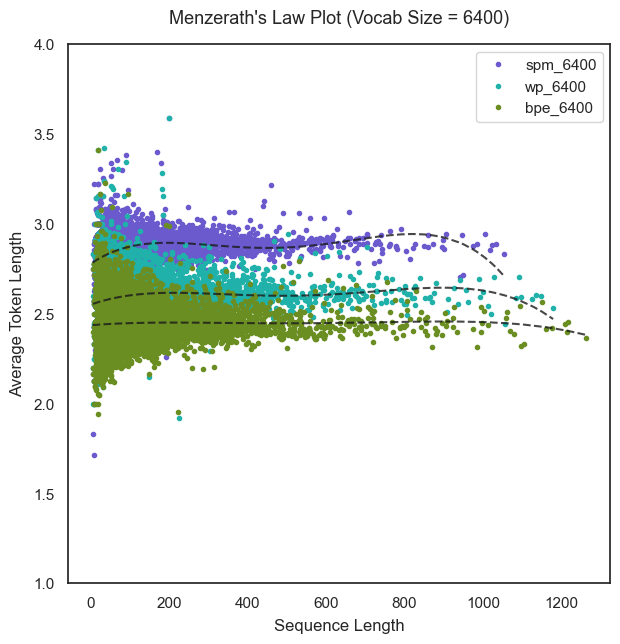

In [1524]:
sns.set_style("white")
vocab_size = vocab_sizes[4]
for i, method in enumerate(methods[::-1]):
    seq_lengths = test_df[f'{method}_{vocab_size}'].apply(len)
    avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    plt.plot(seq_lengths, avg_token_lengths, ".", color=colors[::-1][-3:][i], label=f'{method}_{vocab_size}')
    
for i, method in enumerate(methods[::-1]):
    seq_lengths = test_df[f'{method}_{vocab_size}'].apply(len)
    avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    coefficients = np.polyfit(seq_lengths, avg_token_lengths, 4)
    p = np.poly1d(coefficients)
    y_fit = p(sorted(list(set(seq_lengths))))
    plt.plot(sorted(list(set(seq_lengths))), y_fit, '--k', alpha=.8)


plt.title(f"Menzerath's Law Plot (Vocab Size = {vocab_size})", pad=title_pad, size=13)
# plt.xlim([0, 2000])
plt.ylim([1,4])
plt.xlabel("Sequence Length", labelpad=label_pad)
plt.ylabel("Average Token Length", labelpad=label_pad)
plt.legend()
plt.savefig(f'../RSRC/progress2/figures/menzerath_{vocab_size}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/menzerath_{vocab_size}.png', bbox_inches='tight')
plt.show()

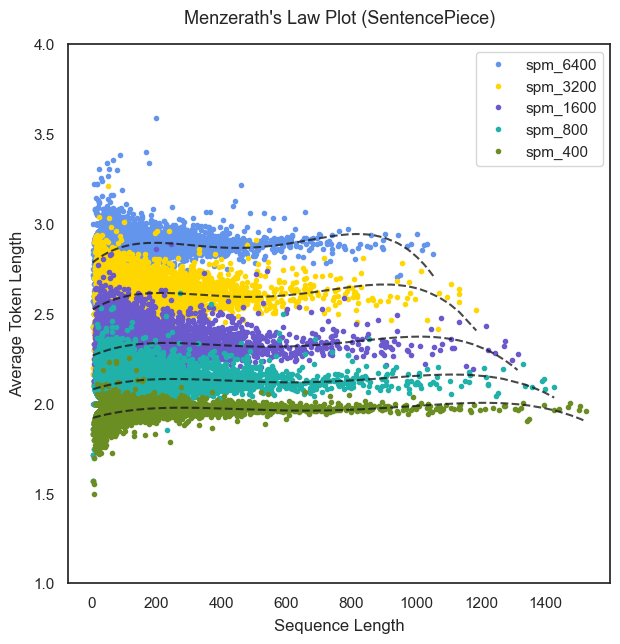

In [1527]:
method = methods[2]
for i, vocab_size in enumerate(vocab_sizes[::-1]):
    seq_lengths = test_df[f'{method}_{vocab_size}'].apply(len)
    avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    plt.plot(seq_lengths, avg_token_lengths, ".", color=colors[::-1][i], label=f'{method}_{vocab_size}')


for i, vocab_size in enumerate(vocab_sizes[::-1]):
    seq_lengths = test_df[f'{method}_{vocab_size}'].apply(len)
    avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    coefficients = np.polyfit(seq_lengths, avg_token_lengths, 4)
    p = np.poly1d(coefficients)
    y_fit = p(sorted(list(set(seq_lengths))))
    plt.plot(sorted(list(set(seq_lengths))), y_fit, '--k', alpha=.8)
    
plt.title(f"Menzerath's Law Plot ({methods2names[method]})", pad=title_pad, size=13)
# plt.xlim([0, 2000])
plt.ylim([1, 4])
plt.xlabel("Sequence Length", labelpad=label_pad)
plt.ylabel("Average Token Length", labelpad=label_pad)
plt.legend()
plt.savefig(f'../RSRC/progress2/figures/menzerath_{methods2names[method]}.pdf', bbox_inches='tight')
plt.savefig(f'../RSRC/progress2/figures/menzerath_{methods2names[method]}.png', bbox_inches='tight')
plt.show()